<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/ViT-paper-replicating/08_pytorch_paper_replicating_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Paper Replicating

The goal of machine learning research paper replicating is: Turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/pdf/2010.11929.pdf

## 0.0 Get setup

Let's import code we've previously written + required libraries.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 36.11 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
# setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.0 Get the data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2.0 Create Datasets and DataLoaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# create image size
IMG_SIZE = 224  # comes from table-3 of the ViT paper
BATCH_SIZE = 32   # paper uses 4096 but it is too big for our smaller hardwere

# creating a transforms pipeline
manual_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x77fe31b0da50>,
 ['pizza', 'steak', 'sushi'])

In [7]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.1 Visualizing a single image

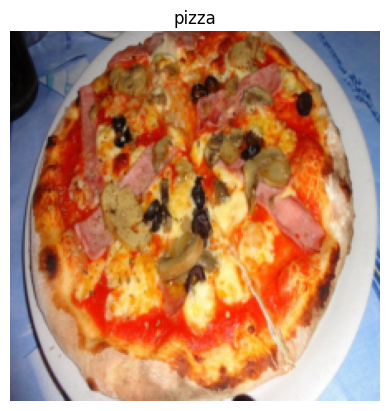

In [8]:
# get a batch of image
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

plt.imshow(image.permute(1, 2, 0))  # (colour_channels, height, width) -> (height, width, colour_channels)
plt.title(class_names[label])
plt.axis(False)
plt.show()

## 3.0 Replicating ViT: Overview

So in order to make it more understandable, we cam break it down into smaller pieces:

* **Inputs** - What dows into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### 3.1 ViT overview: Pices of the puzzle

* Figure 1: Visual overview of the architecture.
* Four equations: Math equations which define the functions of each layer/block.
* Table 1/3: Different hyperparameters for the architecture/training.
* Text



<h3>Figure 1</h3>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true"
height=400 width=800 alt="figure 1">



<h3>Four equations</h3>

$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

<br>

<h3>Section 3.1 describes the various equations</h3>

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

<br>

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix (D.4). The resulting sequence of embedding vectors serves as input to the encoder.

<br>

**In psudocode:**

```python
x_input = [class_token, image_path_1, image_patch_2, ...image_patch_N] +
          [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... Image_patch_N_pos]
```



**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

<br>

In psudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```




**Equation 4:**
Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

<br>

In psudocode:
```python
# Equaiton 4
y = MLP(LN_layer(x_output_MLP_block))
```



<h3>Table 1</h3>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" height=250 width=700 alt="table-1">

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - The number of transformer encoder layers.
* Hidden size $D$ - The embedding size throughout the architecture.
* MLP size - The number of hidden units/neurons in the MLP.
* Head - The number of multi-head self-attention.

**🧮Embedding🧮:** It is a learnable representation of any data (number, text, image, code, video etc). Embeddings contains random numbers and it improves overtime.

## 4.0 Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?
> $H × W × C$ -> (height, width, colour_channels)

<br>

What's the output shape?
> Output shape: $N × (P^2 . C)$

* H = height
* W = width
* C = colour channels
* P = patch size
* N = number of patches = (height * width) / $p^2$
* D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
# create a example values
height = 224
width = 224
colour_channels = 3
patch_size = 16

# calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
print(number_of_patches)

196


In [12]:
# input shape
embedding_layer_input_shape = (height, width, colour_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * colour_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.1 Truning a single image into patches

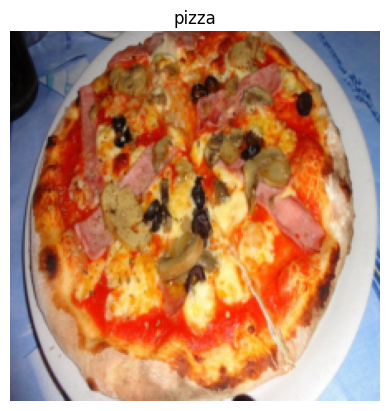

In [11]:
# view a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

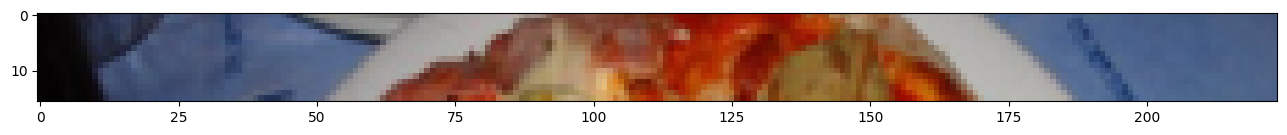

In [25]:
# lets get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.show()

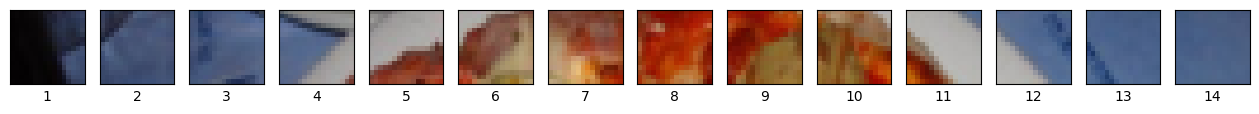

In [28]:
# setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# create a series of subplots
fig, axs = plt.subplots(figsize=(patch_size, patch_size),
                        nrows=1,
                        ncols=img_size // patch_size, # one column for each patches
                        sharex=True,
                        sharey=True)
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)  # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row   : 14
Number of patches per column: 14
Total patches               : 196
Patch size                  : 16 pixels x 16 pixels


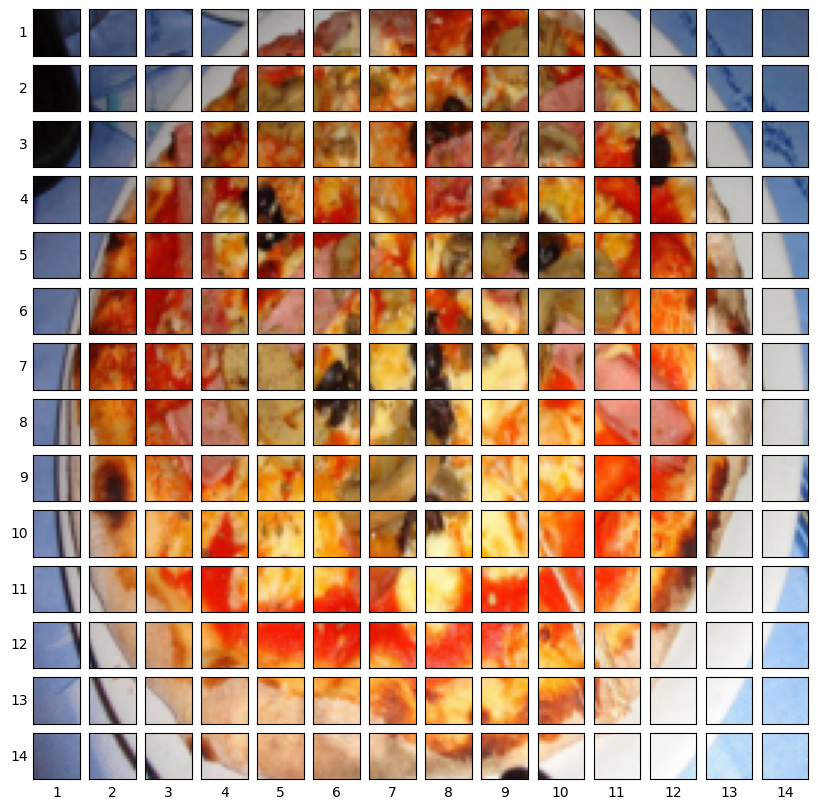

In [36]:
# ploting whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f'''Number of patches per row   : {num_patches}
Number of patches per column: {num_patches}
Total patches               : {num_patches * num_patches}
Patch size                  : {patch_size} pixels x {patch_size} pixels''')

# create a series of subplots
fig, axs = plt.subplots(figsize=(10, 10),
                        nrows=img_size // patch_size,
                        ncols=img_size // patch_size, # one column for each patches
                        sharex=True,
                        sharey=True)
# Iterate through height and width of the image
for i, patch_height, in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # iterate through height
                                    patch_width:patch_width+patch_size,  # iterate through width
                                    :])  # get all colour channels
    # setup label imformation for each subplot (patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i, j].set_xlabel(j+1)  # set the patch label
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()
plt.show()